In [1]:
import pandas as pd
import tensorflow as tf
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime, timedelta

Duplicate key in file '/Users/sharan/.matplotlib/matplotlibrc' line #39.
/Users/sharan/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### Reading Data and Initial Datatype classification/ Feature Engineering

In [2]:
parking = pd.read_csv("../data/merged_data_frame.csv")
# remove random unnamed column
parking = parking.drop(['Unnamed: 0'], axis=1)

In [3]:
# converting to datatime object
parking['date'] = parking['date'].astype('datetime64[ns]') 
parking['month']= pd.DatetimeIndex(parking['date']).month
parking['year'] = pd.DatetimeIndex(parking['date']).year
parking['day'] = pd.DatetimeIndex(parking['date']).weekday
parking['hour'] = pd.DatetimeIndex(parking['date']).hour
parking['weekend'] = parking.day > 5
parking.head()

,date,garageCode,id,precipitation,pressure,symbol,temperature,totalSpaces,vehicleCount,winddirection,windspeed,month,year,day,hour,weekend
0,2018-03-22 13:00:01,NORREPORT,1,0.0,1008.6,Cloudy,4.0,65,19,54.2,2.6,3,2018,3,13,False
1,2018-03-22 13:00:01,SCANDCENTER,2,0.0,1008.6,Cloudy,4.0,1240,575,54.2,2.6,3,2018,3,13,False
2,2018-03-22 13:00:01,BRUUNS,3,0.0,1008.6,Cloudy,4.0,953,605,54.2,2.6,3,2018,3,13,False
3,2018-03-22 13:00:01,MAGASIN,4,0.0,1008.6,Cloudy,4.0,378,282,54.2,2.6,3,2018,3,13,False
4,2018-03-22 13:00:01,KALKVAERKSVEJ,5,0.0,1008.6,Cloudy,4.0,210,195,54.2,2.6,3,2018,3,13,False


### Data Exploration/Cleaning

2019-08-06 14:45:26.594546


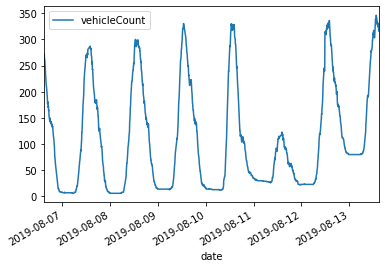

In [44]:
temp = parking[parking.garageCode == 'MAGASIN']
d = datetime.today() - timedelta(weeks=6)
print(d)
temp = temp[(temp.date >  d) & (temp.date < d + timedelta(weeks = 1))]
temp.plot(x='date', y='vehicleCount')

NORREPORT
SCANDCENTER
BRUUNS
MAGASIN
KALKVAERKSVEJ
SALLING
Navitas
NewBusgadehuset
Urban Level 1
Urban Level 2+3


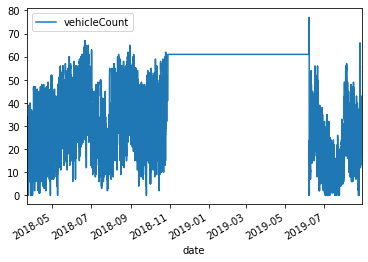

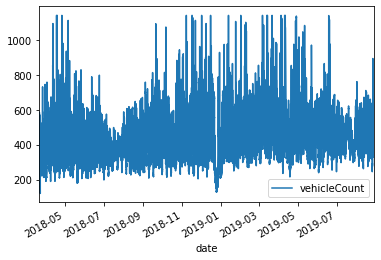

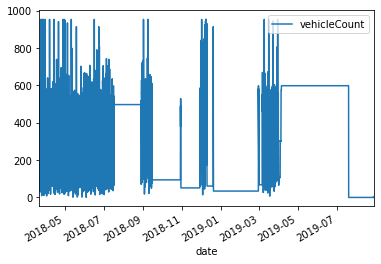

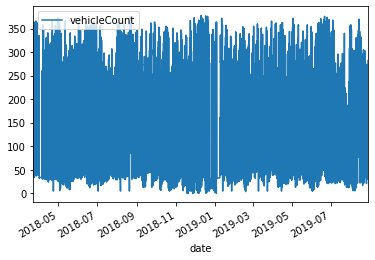

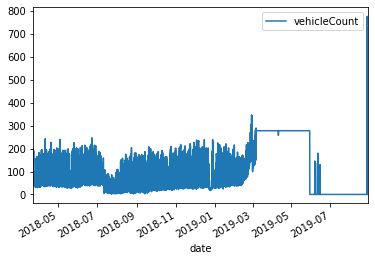

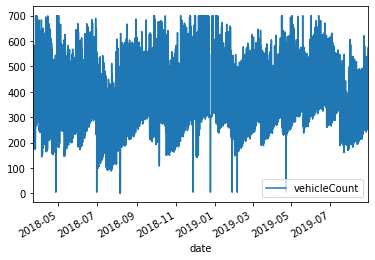

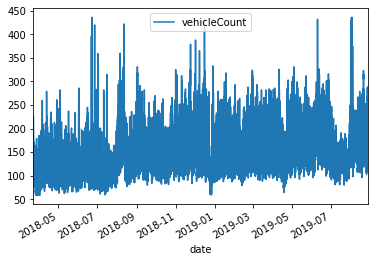

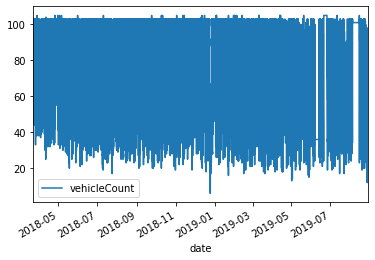

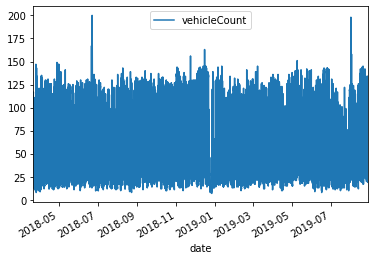

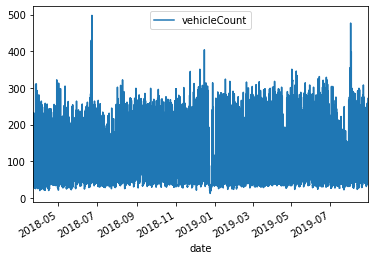

In [45]:
for location in parking.garageCode.unique():
    print(location)
    parking[parking.garageCode == location].plot(x='date', y='vehicleCount')

In [46]:
# removing norreport, bruuns, KALKVAERKSVEJ for substanital missing data
parking = parking[parking.garageCode != 'KALKVAERKSVEJ']
parking = parking[parking.garageCode != 'BRUUNS']
parking = parking[parking.garageCode != 'NORREPORT']
parking.garageCode.unique()

array(['SCANDCENTER', 'MAGASIN', 'SALLING', 'Navitas', 'NewBusgadehuset',
       'Urban Level 1', 'Urban Level 2+3'], dtype=object)

### Granular Analysis and Cleaning

SCANDCENTER
AxesSubplot(0.125,0.125;0.775x0.755)


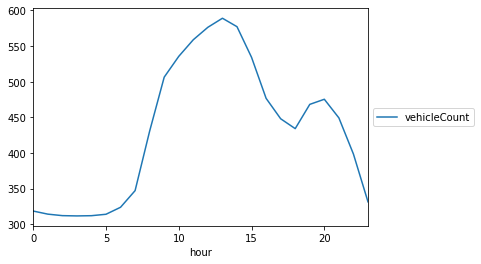

MAGASIN
AxesSubplot(0.125,0.125;0.775x0.755)


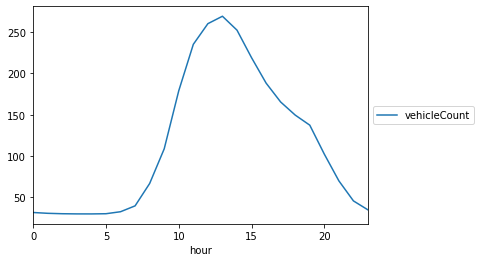

SALLING
AxesSubplot(0.125,0.125;0.775x0.755)


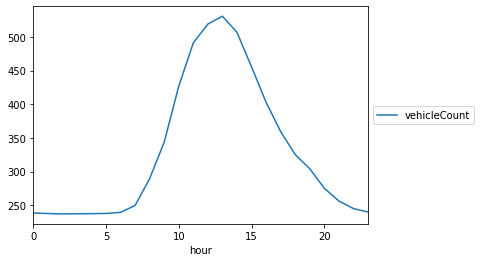

Navitas
AxesSubplot(0.125,0.125;0.775x0.755)


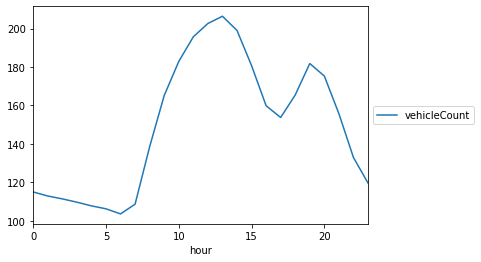

NewBusgadehuset
AxesSubplot(0.125,0.125;0.775x0.755)


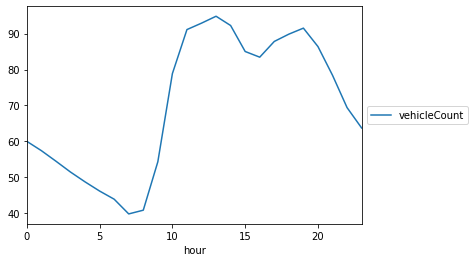

Urban Level 1
AxesSubplot(0.125,0.125;0.775x0.755)


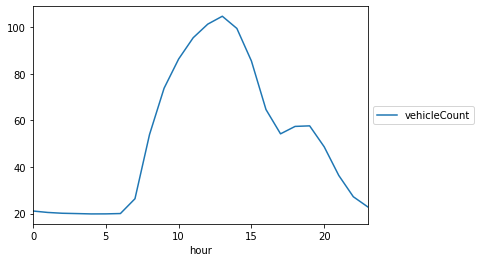

Urban Level 2+3
AxesSubplot(0.125,0.125;0.775x0.755)


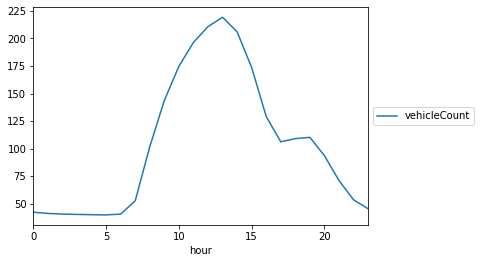

In [47]:
for location in parking.garageCode.unique():
    print(location)
    temp_df = parking[parking.garageCode == location].copy()
    temp_df['percentage'] = temp_df.vehicleCount / temp_df.totalSpaces
    print(temp_df.groupby('hour').mean()['vehicleCount'].plot())
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    plt.show()

In [8]:
for location in parking.garageCode.unique():
    print(location)
    temp_df = parking[parking.garageCode == location].copy()
    temp_df['percentage'] = temp_df.vehicleCount / temp_df.totalSpaces    
    print("Number of entries of collected data:", len(temp_df))
    print("Number of occurences of more cars than spaces:" , len(temp_df[temp_df.percentage > 1]))
    print("Number of occurences per count of total spaces:" , temp_df.groupby('totalSpaces').size().sort_values(ascending=False))
    counts = temp_df.groupby('totalSpaces').size().sort_values(ascending=False).reset_index()
    if len(counts) > 1:
        print(temp_df[temp_df.totalSpaces == counts['totalSpaces'].iloc[1]])


NORREPORT
Number of entries of collected data: 148052
Number of occurences of more cars than spaces: 20
Number of occurences per count of total spaces: totalSpaces
65    90093
80    57959
dtype: int64
bumpb
SCANDCENTER
Number of entries of collected data: 148052
Number of occurences of more cars than spaces: 0
Number of occurences per count of total spaces: totalSpaces
1240    148052
dtype: int64
BRUUNS
Number of entries of collected data: 148052
Number of occurences of more cars than spaces: 1
Number of occurences per count of total spaces: totalSpaces
953    148051
0           1
dtype: int64
bumpb
MAGASIN
Number of entries of collected data: 148052
Number of occurences of more cars than spaces: 0
Number of occurences per count of total spaces: totalSpaces
378    148035
380        17
dtype: int64
bumpb
KALKVAERKSVEJ
Number of entries of collected data: 148052
Number of occurences of more cars than spaces: 25752
Number of occurences per count of total spaces: totalSpaces
210    138151


In [49]:
# fixing the magasin erros in data
parking.loc[parking.garageCode == 'MAGASIN', 'totalSpaces'] = 378
parking[parking.garageCode == 'MAGASIN'].totalSpaces.unique()

array([378])

In [50]:
# fixing the NewBusgadehuset erros in data
parking.loc[parking.garageCode == 'NewBusgadehuset', 'totalSpaces'] = 105
parking[parking.garageCode == 'NewBusgadehuset'].totalSpaces.unique()

array([105])

In [51]:
# fixing the Urban Leve 2 + 3 erros in data
parking.loc[parking.garageCode == 'Urban Level 2+3', 'totalSpaces'] = 654
parking[parking.garageCode == 'Urban Level 2+3'].totalSpaces.unique()

array([654])

In [52]:
# fixing the Navitas errors:

# locate the bad data
temp_df = parking[parking.garageCode == 'Navitas']
bad_data = temp_df[temp_df.totalSpaces == 100]
bad_data.head()

,date,garageCode,id,precipitation,pressure,symbol,temperature,totalSpaces,vehicleCount,winddirection,windspeed,month,year,day,hour,weekend
1186833,2019-05-14 21:55:01,Navitas,8,0.0,1032.5,Clear sky,12.0,100,233,151.5,1.6,5,2019,1,21,False
1186843,2019-05-14 22:00:02,Navitas,8,0.0,1032.3,Clear sky,11.0,100,233,159.8,1.3,5,2019,1,22,False
1186853,2019-05-14 22:05:01,Navitas,8,0.0,1032.3,Clear sky,11.0,100,233,159.8,1.3,5,2019,1,22,False
1186863,2019-05-14 22:10:01,Navitas,8,0.0,1032.3,Clear sky,11.0,100,233,159.8,1.3,5,2019,1,22,False
1186873,2019-05-14 22:15:01,Navitas,8,0.0,1032.3,Clear sky,11.0,100,233,159.8,1.3,5,2019,1,22,False


Notes on the bad data:
- not a weekend
- occured during an early morning from the week before

Solution:
- use the previous 3 weeks worth of data at the exact time to average out the count of vehicles over this time period and use to fill in the vehicle count here

In [53]:
days_to_subtract = 1
d = datetime.today() - timedelta(weeks=days_to_subtract)

replacement_avg_values = []
dates = []
for index, row in bad_data.iterrows():
    dates.append(row[0])
    count = 0
    for week_num in range(3):
        date_1 = row[0] - timedelta(weeks=week_num)
        internal_df = temp_df[temp_df.date == date_1]
        if len(internal_df) == 0:
            date_1 = date_1 - timedelta(seconds=1)
            internal_df = temp_df[temp_df.date == date_1]
        if len(internal_df) == 0:
            date_1 = date_1 + timedelta(seconds=2)
            internal_df = temp_df[temp_df.date == date_1] 
        count += internal_df.iloc[0]['vehicleCount']
    replacement_avg_values.append(int(count/3))

new_data = pd.DataFrame()
new_data['date'] = dates 
new_data['date'] = new_data['date'].astype('datetime64[ns]') 
new_data['vehicleCount'] = replacement_avg_values
new_data['totalSpaces'] = 449

In [54]:
# merge and fix the navitas data
for index, row in new_data.iterrows():
    parking.loc[(parking.garageCode == 'Navitas') & (parking.date == row['date']), 'vehicleCount'] == row['vehicleCount']
    
parking.loc[parking.garageCode == 'Navitas', 'totalSpaces'] = 449
parking[parking.garageCode == 'Navitas'].totalSpaces.unique()

array([449])

In [74]:
for location in parking.garageCode.unique():
    print(location)
    temp_df = parking[parking.garageCode == location].copy()
    temp_df['percentage'] = temp_df.vehicleCount / temp_df.totalSpaces    
    print("Number of entries of collected data:", len(temp_df))
    print("Number of occurences with more than 10% more cars than spaces:" , len(temp_df[temp_df.percentage > 1.1]))
    print("Number of totalSpace counts:" , len(temp_df.groupby('totalSpaces').size().sort_values(ascending=False)))
    print("Number of vehicleCount inf values:" , len(temp_df[temp_df.vehicleCount == np.inf]))
    counts = temp_df.groupby('totalSpaces').size().sort_values(ascending=False).reset_index()
    if len(counts) > 1:
        print(temp_df[temp_df.totalSpaces == counts['totalSpaces'].iloc[1]])
    print()
    

find_inf_df = parking
find_inf_df.index = find_inf_df.date
find_inf_df = find_inf_df[['vehicleCount']]
print(find_inf_df.index[np.isinf(find_inf_df).any(1)])
from dateutil import parser
#dt = parser.parse("2018-11-18 20:40:01")
#find_inf_df[find_inf_df.index == dt]


SCANDCENTER
Number of entries of collected data: 148052
Number of occurences with more than 10% more cars than spaces: 0
Number of totalSpace counts: 1
Number of vehicleCount inf values: 0

MAGASIN
Number of entries of collected data: 148052
Number of occurences with more than 10% more cars than spaces: 0
Number of totalSpace counts: 1
Number of vehicleCount inf values: 0

SALLING
Number of entries of collected data: 148052
Number of occurences with more than 10% more cars than spaces: 0
Number of totalSpace counts: 1
Number of vehicleCount inf values: 0

Navitas
Number of entries of collected data: 148052
Number of occurences with more than 10% more cars than spaces: 0
Number of totalSpace counts: 1
Number of vehicleCount inf values: 0

NewBusgadehuset
Number of entries of collected data: 148052
Number of occurences with more than 10% more cars than spaces: 0
Number of totalSpace counts: 1
Number of vehicleCount inf values: 0

Urban Level 1
Number of entries of collected data: 148052


## Feature Engineering

In [75]:
# adding percentage column
parking['percentage'] = parking['vehicleCount'] / parking['totalSpaces']

In [76]:
# adding raining column
parking['raining?'] = parking.precipitation > 0 

In [77]:
find_inf_df = parking
find_inf_df.index = find_inf_df.date
find_inf_df = find_inf_df[['vehicleCount']]
print(find_inf_df.index[np.isinf(find_inf_df).any(1)])


DatetimeIndex([], dtype='datetime64[ns]', name='date', freq=None)


In [78]:
parking.to_csv("cleaned_df.csv")

data all cleaned and seems ready for model development

## Data Exploration pt. 2

SCANDCENTER
AxesSubplot(0.125,0.125;0.775x0.755)


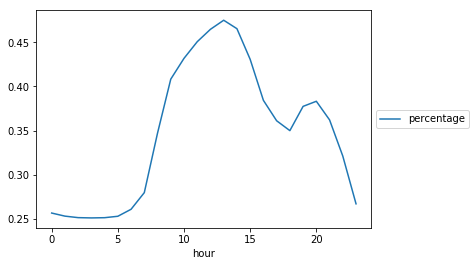

MAGASIN
AxesSubplot(0.125,0.125;0.775x0.755)


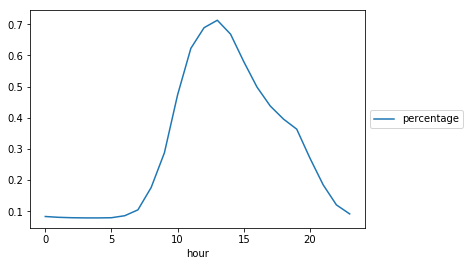

SALLING
AxesSubplot(0.125,0.125;0.775x0.755)


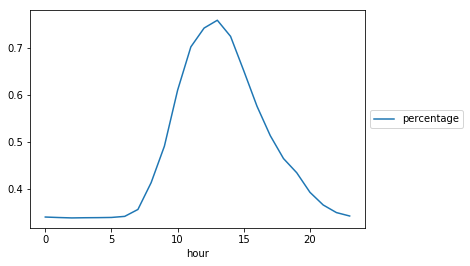

Navitas
AxesSubplot(0.125,0.125;0.775x0.755)


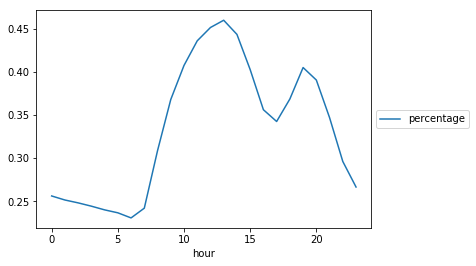

NewBusgadehuset
AxesSubplot(0.125,0.125;0.775x0.755)


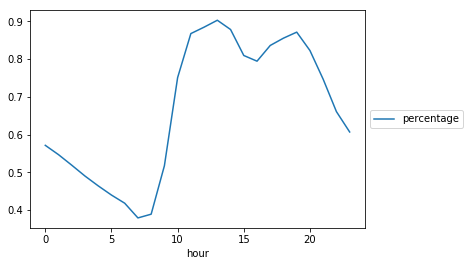

Urban Level 1
AxesSubplot(0.125,0.125;0.775x0.755)


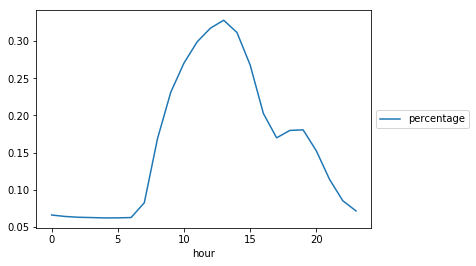

Urban Level 2+3
AxesSubplot(0.125,0.125;0.775x0.755)


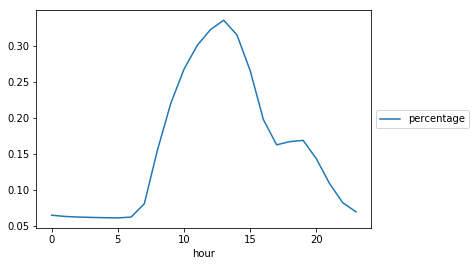

In [18]:
for location in parking.garageCode.unique():
    print(location)
    temp_df = parking[parking.garageCode == location].copy()
    print(temp_df.groupby('hour').mean()['percentage'].plot())
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    plt.show()

SCANDCENTER


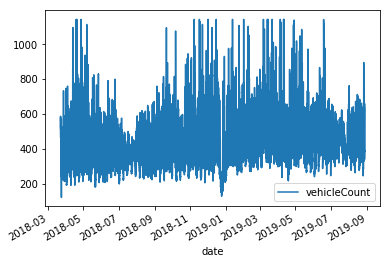

MAGASIN


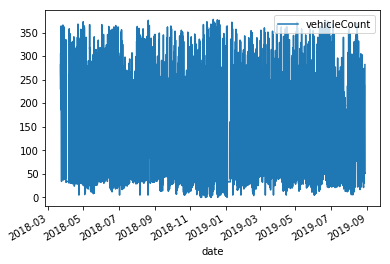

SALLING


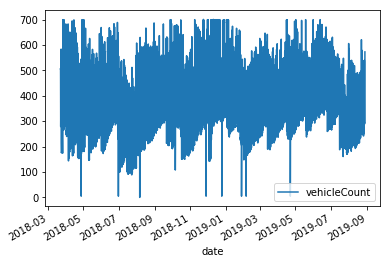

Navitas


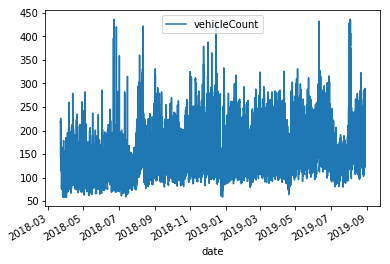

NewBusgadehuset


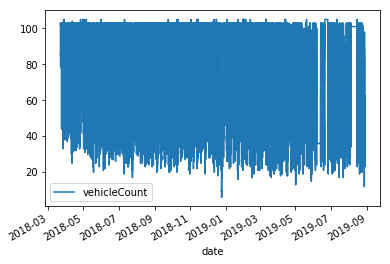

Urban Level 1


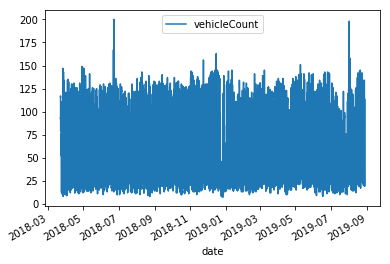

Urban Level 2+3


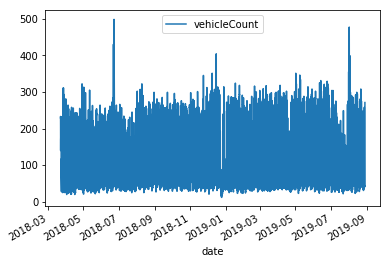

In [19]:
for location in parking.garageCode.unique():
    print(location)
    parking[parking.garageCode == location].plot(x='date', y='vehicleCount')
    plt.show()

In [20]:
parking.index = parking.date

## Seasonality Analysis

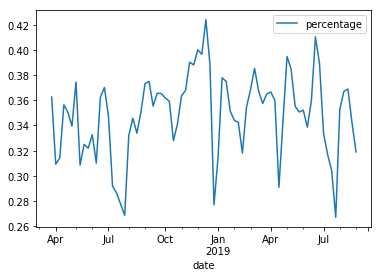

In [21]:
parking.resample('W').mean().plot( y='percentage')

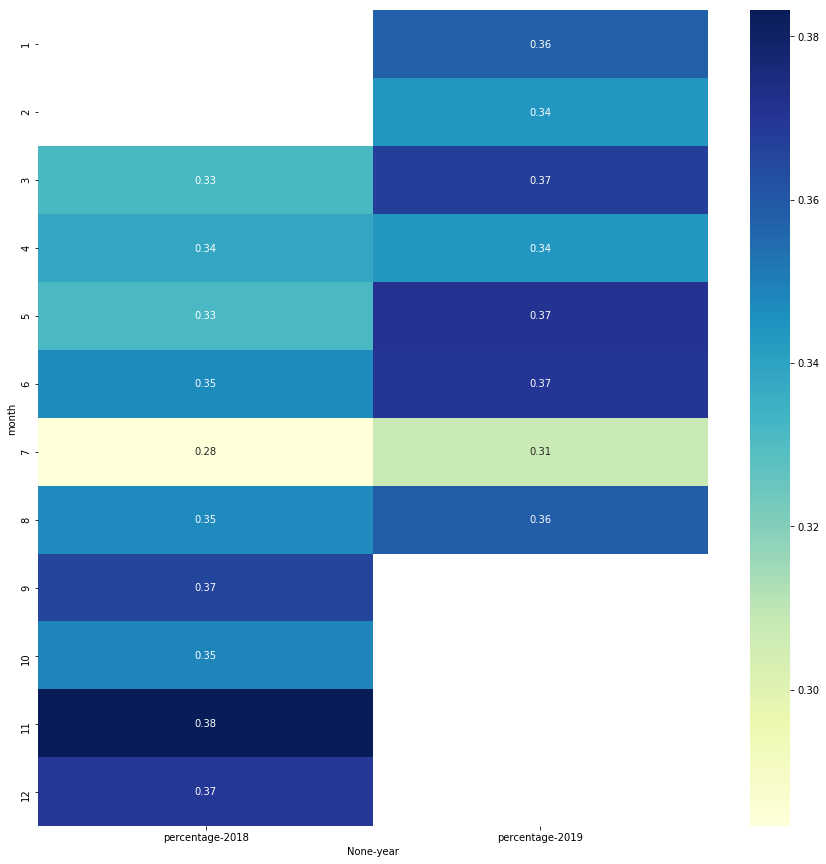

In [22]:
parking_pivot = parking.pivot_table(index='month', columns='year', values=['percentage'])
plt.figure(figsize=(15, 15))
sns.heatmap(parking_pivot, annot=True, cmap="YlGnBu")
plt.show()

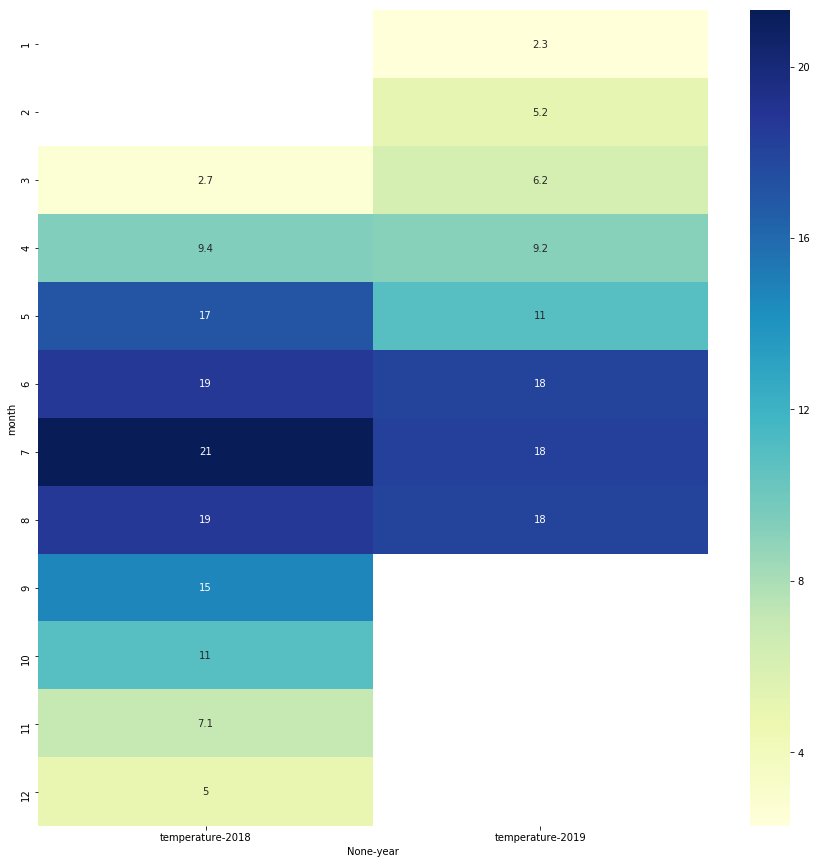

In [23]:
temp_pivot = parking.pivot_table(index='month', columns='year', values=['temperature'])
plt.figure(figsize=(15, 15))
sns.heatmap(temp_pivot, annot=True, cmap="YlGnBu")
plt.show()

### Stationary Check vs. Non-Stationary Check
Stationary is basically a description of the data to see if there is a seasonality effect in place. 

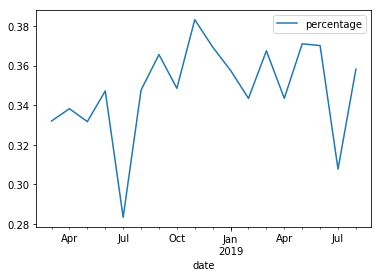

In [24]:
parking.resample('M').mean().plot( y='percentage')

In [25]:
parking[0: int(len(parking)/3)].describe()['percentage']

count    345454.000000
mean          0.332199
std           0.243018
min           0.000000
25%           0.155902
50%           0.275000
75%           0.428571
max           1.000000
Name: percentage, dtype: float64

In [26]:
parking[int(len(parking)/3) + 1 : int(len(parking)/3) * 2].describe()['percentage']

count    345453.000000
mean          0.361141
std           0.251848
min           0.000000
25%           0.167038
50%           0.322581
75%           0.483296
max           1.001429
Name: percentage, dtype: float64

In [27]:
parking[int(len(parking)/3) * 2 + 1: ].describe()['percentage']

count    345455.000000
mean          0.352455
std           0.236246
min           0.007143
25%           0.162080
50%           0.320106
75%           0.471429
max           1.000000
Name: percentage, dtype: float64

Looking at the breakdown above, seems as if the data is all quite stationary as depcited by a relatively similar mean and standard deviation over time. This bodes well, as it means that we are allowed to use the ARIMA model.

### Running a Statistcal Test to confirm

In [28]:
from statsmodels.tsa.stattools import adfuller
import numpy as np

for garage in parking.garageCode.unique():
    temp = parking[parking.garageCode == garage]
    X = temp['vehicleCount'].values
    #X = np.log(X)
    result = adfuller(X)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))


ADF Statistic: -33.587550
p-value: 0.000000
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567
ADF Statistic: -44.101354
p-value: 0.000000
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567
ADF Statistic: -34.830648
p-value: 0.000000
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567
ADF Statistic: -32.326630
p-value: 0.000000
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567
ADF Statistic: -34.680448
p-value: 0.000000
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567
ADF Statistic: -43.099528
p-value: 0.000000
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567
ADF Statistic: -43.491920
p-value: 0.000000
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567


In [29]:
#define function for kpss test
from statsmodels.tsa.stattools import kpss
#define KPSS
def kpss_test(timeseries):
    print ('Results of KPSS Test:')
    kpsstest = kpss(timeseries, regression='c')
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print(kpss_output)

kpss_test(X)

Results of KPSS Test:
Test Statistic            0.465837
p-value                   0.049361
Lags Used                75.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


/Users/sharan/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1685: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)


In [30]:
from statsmodels.tsa.arima_model import ARIMA
# for garage in parking.garageCode.unique():
#     print(garage)
temp2 = parking[parking.garageCode == "SALLING"]
temp2 = temp2['vehicleCount'].astype(int)
temp = pd.DataFrame()
temp['vehicleCount'] = temp2
# 1,1,2 ARIMA Model
model = ARIMA(temp.vehicleCount, order=(2,0,1))
model_fit = model.fit(disp=0)
print(model_fit.summary())


/Users/sharan/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                              ARMA Model Results                              
Dep. Variable:           vehicleCount   No. Observations:               148052
Model:                     ARMA(2, 1)   Log Likelihood             -434332.496
Method:                       css-mle   S.D. of innovations              4.548
Date:                Thu, 12 Sep 2019   AIC                         868674.992
Time:                        11:30:20   BIC                         868724.519
Sample:                             0   HQIC                        868689.762
                                                                              
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                329.1684      2.369    138.962      0.000     324.526     333.811
ar.L1.vehicleCount     1.9842      0.001   3654.166      0.000       1.983       1.985
ar.L2.vehicleCount  

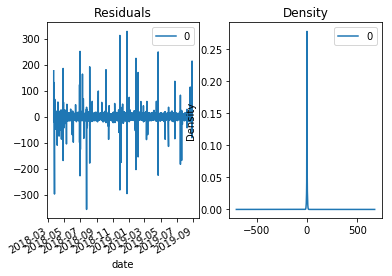

In [31]:
# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()


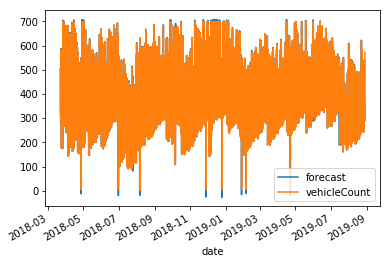

In [32]:
# Actual vs Fitted
model_fit.plot_predict(dynamic=False)
plt.show()

In [33]:
from statsmodels.tsa.stattools import acf

# Create Training and Test
train = temp.vehicleCount[:85]
test = temp.vehicleCount[85:]

/Users/sharan/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/sharan/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


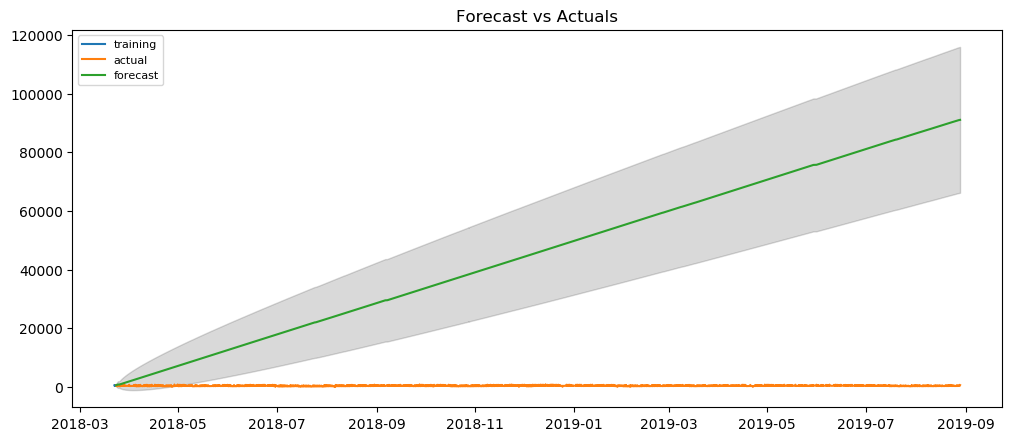

In [34]:
# Build Model
# model = ARIMA(train, order=(3,2,1))  
model = ARIMA(train, order=(1, 1, 1))  
fitted = model.fit(disp=-1)  

# Forecast
fc, se, conf = fitted.forecast(len(test), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [35]:
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    acf1 = acf(fc-test)[1]                      # ACF1
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'acf1':acf1, 
            'corr':corr, 'minmax':minmax})

forecast_accuracy(fc, test.values)

/Users/sharan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/sharan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  
/Users/sharan/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


{'mape': inf,
 'me': 45511.750652190174,
 'mae': 45511.75368974814,
 'mpe': inf,
 'rmse': 52478.7220236442,
 'acf1': 0.9999796849917213,
 'corr': 0.09407248922915157,
 'minmax': 0.9821530811898678}

### Using a prebuilt system

In [36]:
import warnings
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')


In [37]:
y = pd.DataFrame({'vehicleCount':temp.vehicleCount})


In [38]:
# this aggreagates the data per hour 
y = y['vehicleCount'].resample('H').mean()

# The term bfill means that we use the value before filling in missing values
y = y.fillna(y.bfill())

print(y.head())


date
2018-03-22 13:00:00    502.750000
2018-03-22 14:00:00    486.750000
2018-03-22 15:00:00    407.666667
2018-03-22 16:00:00    339.166667
2018-03-22 17:00:00    318.500000
Freq: H, Name: vehicleCount, dtype: float64


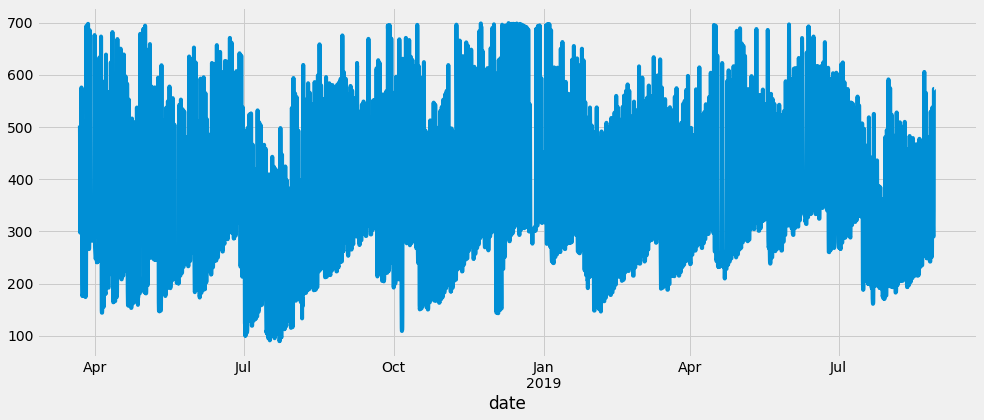

In [39]:
y.plot(figsize=(15, 6))
plt.show()


In [40]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA…')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA…
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [45]:
warnings.filterwarnings("ignore") # specify to ignore warning messages

params = []
param_seasonals = []
aics = []
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
            params.append(param)
            param_seasonals.append(param_seasonal)
            aics.append(results.aic)
        except:
            continue
        
results = pd.DataFrame()
results['params'] = params
results['param_seasonals'] = param_seasonals
results['aics'] = aics

results.sort_values('aics', ascending=False)

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:183312.052150889
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:178620.48794359114
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:170011.57093480168
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:155986.8304249809
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:168868.70596357223
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:156134.9532360082
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:144869.77151315217
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:144860.13480077707
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:166411.15527256124
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:161772.1989874095
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:153203.35263098637
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:140174.97135999054
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:152162.7563667493
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:140312.56491195632
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:130354.28596109847
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:130326.03449897125
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:128135.6677844335
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:127737.99161059121

,params,param_seasonals,aics
0,"(0, 0, 0)","(0, 0, 0, 12)",183312.052151
1,"(0, 0, 0)","(0, 0, 1, 12)",178620.487944
2,"(0, 0, 0)","(0, 1, 0, 12)",170011.570935
4,"(0, 0, 0)","(1, 0, 0, 12)",168868.705964
8,"(0, 0, 1)","(0, 0, 0, 12)",166411.155273
9,"(0, 0, 1)","(0, 0, 1, 12)",161772.198987
5,"(0, 0, 0)","(1, 0, 1, 12)",156134.953236
3,"(0, 0, 0)","(0, 1, 1, 12)",155986.830425
10,"(0, 0, 1)","(0, 1, 0, 12)",153203.352631
12,"(0, 0, 1)","(1, 0, 0, 12)",152162.756367


In [46]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5714      0.009     60.847      0.000       0.553       0.590
ma.L1          0.1868      0.009     19.989      0.000       0.168       0.205
ar.S.L12      -0.4212      0.005    -76.814      0.000      -0.432      -0.410
ma.S.L12      -0.9445      0.003   -347.952      0.000      -0.950      -0.939
sigma2       382.0703      1.833    208.414      0.000     378.477     385.663


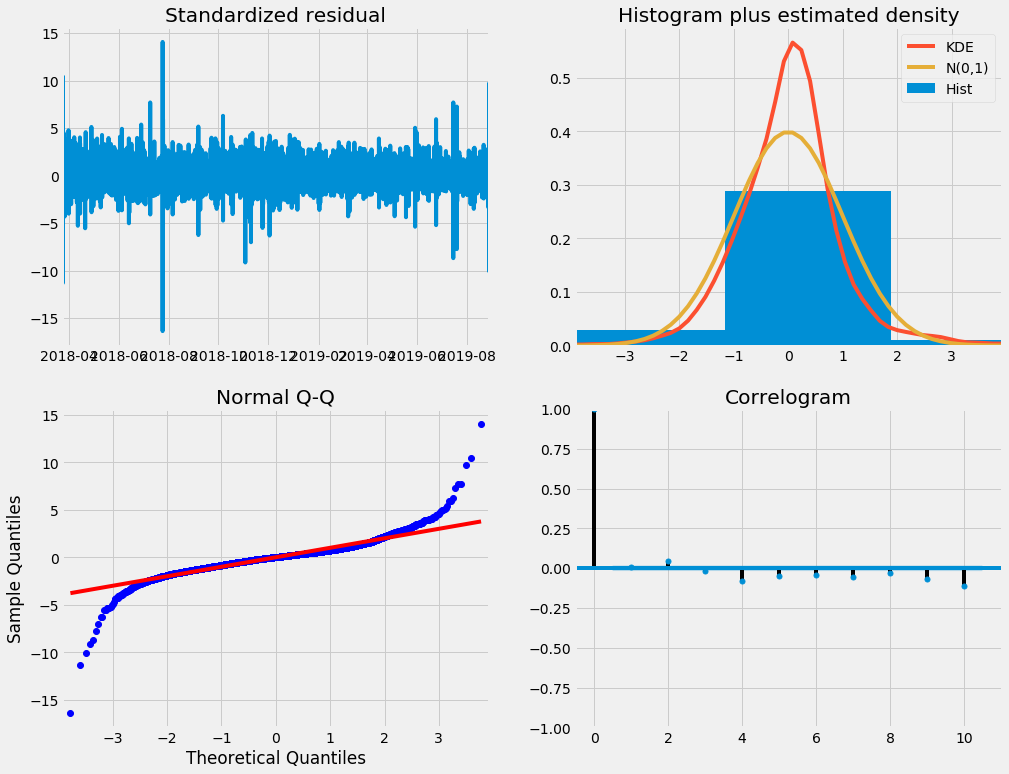

In [47]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()


### RNN with LTSM test

In [53]:
df = parking[parking.garageCode == "SALLING"]


In [54]:
from sklearn.model_selection import train_test_split
TRAIN,TEST,notused,notused = train_test_split(df['percentage'],
                                                    df['percentage'], 
                                                    test_size=0.25)
TRAIN.sort_index(inplace=True)
TEST.sort_index(inplace=True)


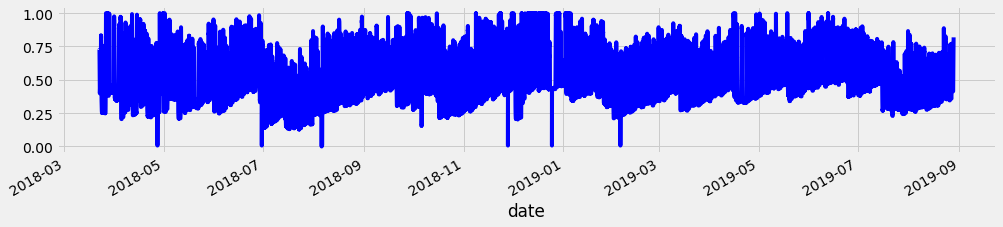

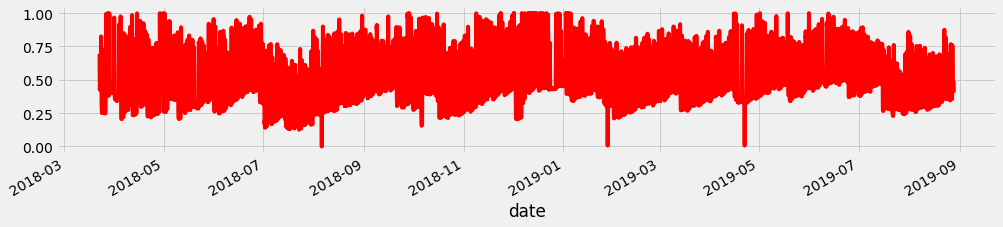

In [55]:
plt.figure(figsize=(15,3));
TRAIN.plot(color='blue')
plt.show();

plt.figure(figsize=(15,3));
TEST.plot(color='red',sharex=True)
plt.show()

In [56]:
# create train lists
x_train = []
y_train = []

# create test lists
x_test = []
y_test = []

# fill the train lists
for i in range(len(TRAIN)-1):
    x_train.append(TRAIN[i])
    y_train.append(TRAIN[i+1])

# fill the test lists
for i in range(len(TEST)-1):
    x_test.append(TEST[i])
    y_test.append(TEST[i+1])

# change the lists to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)
x_test, y_test = np.array(x_test), np.array(y_test)

print(x_train.shape)
print(x_test.shape)

(111038,)
(37012,)


In [57]:
trainX = x_train.reshape(x_train.shape[0], 1, 1)
trainY = y_train.reshape(y_train.shape[0], 1, 1)


In [59]:
x_train = x_train.reshape(1,111038,1)
y_train = x_train.reshape(1,111038,1)

x_test = x_test.reshape(1,37012,1)
y_test = x_test.reshape(1,37012,1)

In [60]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM

Using TensorFlow backend.


In [78]:
from sklearn import cross_validation
import datetime

#### two layer cross validation decision tree
#select X and Y                                                
x = x_train
y = y_train

# Tree complexity parameter - constraint on maximum depth
Denseness = np.arange(1, 120, )


# Initialize variable
NN_Error_train = np.empty((len(Denseness)))
NN_Error_test = np.empty((len(Denseness)))

# inner loop (model selection)
for i, t in enumerate(Denseness):
       
    model = Sequential()

    # adding layers
    model.add(LSTM(t, input_shape=(None,1), return_sequences=True))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation = 'linear'))

    # tweaking settings
    #adam = optimizers.Adam(lr=0.001, beta_1=0.9,
    #beta_2=0.999, epsilon=1e-08, decay=0.0)
    #model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
    model.compile(loss='mean_absolute_error', optimizer='adam',metrics=['accuracy'])

    
    print('fitting model')
    # fitting model
    history = model.fit(x,y, validation_data=(x_test,y_test),
    epochs = 25, batch_size=1, shuffle=False,verbose=0)
    print('predicting')
    # predict
    y_est_test = model.predict(x_test, batch_size = 1000).reshape((-1,))
    y_est_train = model.predict(x_train, batch_size = 1000).reshape((-1,))

    #evaluate misclasification in the current Kfold
    misclass_rate_test = sum(np.abs(y_est_test - y_test.reshape(37012))) / float(len(y_est_test))
    misclass_rate_train = sum(np.abs(y_est_train - y_train.reshape(111038))) / float(len(y_est_train))
    NN_Error_test[i], NN_Error_train[i] = misclass_rate_test, misclass_rate_train

fitting model
predicting
fitting model
predicting


In [ ]:
NN_Error_test

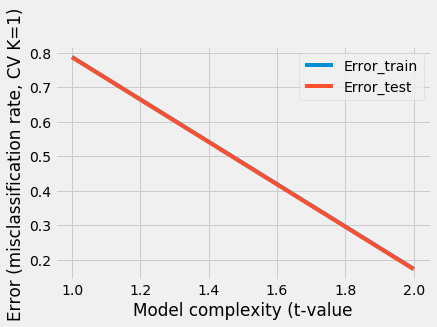

In [80]:
f = plt.figure()
plt.plot(Denseness, NN_Error_train)
plt.plot(Denseness, NN_Error_test)
plt.xlabel('Model complexity (t-value')
plt.ylabel('Error (misclassification rate, CV K={0})'.format(1))
plt.legend(['Error_train','Error_test'])
    
plt.show()

In [81]:
model = Sequential()
model.add(LSTM(95, input_shape=(None,1), return_sequences=True))
model.add(Dropout(0.2))
model.add(Dense(1, activation = 'linear'))
model.compile(loss='mean_absolute_error', optimizer='adam',metrics=['accuracy'])
model.fit(x_train, y_train, epochs=100, batch_size=1, verbose=2,validation_data=(x_test, y_test))
y_pred = model.predict(x_test)

Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x154056908>>
Traceback (most recent call last):
  File "/Users/sharan/anaconda3/lib/python3.6/site-packages/tensorflow/python/client/session.py", line 1448, in __del__
    def __del__(self):
KeyboardInterrupt


Train on 1 samples, validate on 1 samples
Epoch 1/100
 - 97s - loss: 0.4474 - acc: 1.8012e-05 - val_loss: 0.4038 - val_acc: 2.7018e-05
Epoch 2/100


KeyboardInterrupt: 

In [40]:
find_inf_df = parking
find_inf_df = find_inf_df[find_inf_df.garageCode == "MAGASIN"]
from dateutil import parser
dt = parser.parse("2018-11-18 20:40:01")
find_inf_df[find_inf_df.date == dt]


,date,garageCode,id,precipitation,pressure,symbol,temperature,totalSpaces,vehicleCount,winddirection,windspeed,month,year,day,hour,weekend,percentage,raining?
681233,2018-11-18 20:40:01,MAGASIN,4,0.0,1036.0,Cloudy,6.0,378,1,56.4,4.8,11,2018,6,20,True,0.002646,False
